<a href="https://colab.research.google.com/github/kimHySoo/autumn/blob/main/202001159_%EA%B9%80%ED%98%95%EC%88%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

이번 주차 과제는 간단한 이미지 데이터를 활용해 크기가 큰 데이터의 차원 축소를 진행하고 데이터의 라벨에 따라 클러스터링을 진행하는 과제입니다.

###필요한 모듈을 가져오세요.

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

# Image data 가져오기
https://www.kaggle.com/datasets/zalando-research/fashionmnist/data

###위 링크의 fashion mnist 데이터의 train dataset과 test dataset을 가져오세요.
(데이터의 용량이 크니 직접 다운로드 하지 말고 코드를 이용해 가져오도록 해보세요.)

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


###데이터에 대한 정보들을 보여주세요.
(필수: 요약, 모양, 크기, 결측치 여부 등)

In [3]:
data_info = {
    "Dataset": ["Train Images", "Train Labels", "Test Images", "Test Labels"],
    "Shape": [train_images.shape, train_labels.shape, test_images.shape, test_labels.shape],
    "Data Type": [train_images.dtype, train_labels.dtype, test_images.dtype, test_labels.dtype],
    "Size": [train_images.size, train_labels.size, test_images.size, test_labels.size],
    "Min Value": [train_images.min(), train_labels.min(), test_images.min(), test_labels.min()],
    "Max Value": [train_images.max(), train_labels.max(), test_images.max(), test_labels.max()],
    "Missing Values": [
        np.isnan(train_images).sum() + np.isinf(train_images).sum(),
        np.isnan(train_labels).sum() + np.isinf(train_labels).sum(),
        np.isnan(test_images).sum() + np.isinf(test_images).sum(),
        np.isnan(test_labels).sum() + np.isinf(test_labels).sum()
    ]
}

# 데이터를 DataFrame으로 정리하여 표시
data_info_df = pd.DataFrame(data_info)
print(data_info_df)


        Dataset            Shape Data Type      Size  Min Value  Max Value  \
0  Train Images  (60000, 28, 28)     uint8  47040000          0        255   
1  Train Labels         (60000,)     uint8     60000          0          9   
2   Test Images  (10000, 28, 28)     uint8   7840000          0        255   
3   Test Labels         (10000,)     uint8     10000          0          9   

   Missing Values  
0               0  
1               0  
2               0  
3               0  


### Data중 첫 번째 이미지를 보여주세요.

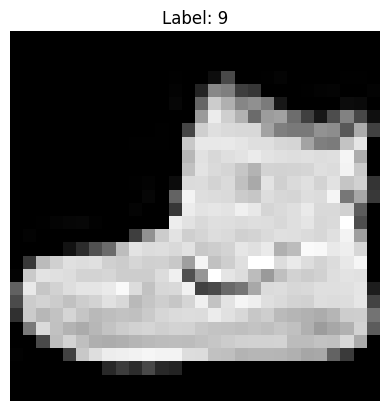

In [4]:
first_image = train_images[0]
first_label = train_labels[0]

# 이미지 시각화
plt.imshow(first_image, cmap='gray')
plt.title(f"Label: {first_label}")
plt.axis('off')
plt.show()


# 이미지 전처리

### 이미지 데이터를 머신러닝에 이용하기 편한 형태로 바꾸어 합니다.
(torch model 사용 - tensor 형태로 바꾸기 등)

In [6]:
# 데이터 변환 설정 (이미지 데이터를 텐서 형태로 변환)
transform = transforms.Compose([
    transforms.ToTensor(),               # Tensor로 변환
    transforms.Normalize((0.5,), (0.5,)) # 0.5를 평균, 표준편차로 정규화
])

# Fashion MNIST 데이터셋 로드 (train, test 데이터 분리)
train_dataset = datasets.FashionMNIST(root='data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='data', train=False, transform=transform, download=True)

# DataLoader 생성 (batch_size 설정으로 데이터를 배치 단위로 처리)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 예시: 첫 번째 배치의 이미지와 라벨 가져오기
images, labels = next(iter(train_loader))
print(f"Images shape: {images.shape}")  # (배치 크기, 채널 수, 높이, 너비) 형태
print(f"Labels shape: {labels.shape}")


100%|██████████| 26.4M/26.4M [00:01<00:00, 16.1MB/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 268kB/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 4.41MB/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 15.3MB/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw

Images shape: torch.Size([64, 1, 28, 28])
Labels shape: torch.Size([64])


:### 이미지 데이터는 픽셀 값이 0 - 255로 이루어져 있습니다. 이 값을 0 - 1까지의 값으로 normalize 해주세요.

In [7]:

transform = transforms.Compose([
    transforms.ToTensor(),               # Tensor로 변환 (0-255를 0-1로 스케일링)
    transforms.Normalize((0.0,), (1.0,)) # 추가 정규화 없이 0-1 값 유지
])

# 첫 번째 이미지의 최소 및 최대 값 확인 (0에서 1 사이인지 확인)
print(f"Image min: {images.min()}, Image max: {images.max()}")


Image min: -1.0, Image max: 1.0


### 추가적인 이미지 전처리를 진행해주세요.
(차원을 수정하는 것은 뒤의 문제에서 진행할 것이므로 여기에서 하지 마세요.)

In [8]:
# 추가적인 이미지 전처리 설정
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5), # 50% 확률로 수평 뒤집기
    transforms.RandomRotation(10),          # ±10도 내외로 회전
    transforms.ToTensor(),                  # Tensor로 변환 (0-255를 0-1로 스케일링)
    transforms.Normalize((0.0,), (1.0,))    # 추가 정규화 없이 0-1 값 유지
])

print(f"Image min: {images.min()}, Image max: {images.max()}")

Image min: -1.0, Image max: 1.0


# 차원 축소
차원 축소란 고차원 데이터를 효율적으로 처리하기 위한 기법입니다.
### 그 중 대표적인 PCA와 t-sne에 대한 내용을 비교하여 아래에 적어주세요.

PCA는 선형적 특성을 가진 데이터를 단순하고 빠르게 축소하기 좋으며, t-SNE는 비선형적 특성이 강한 데이터를 시각화하거나 군집을 파악하는 데 유리합니다. 데이터의 특성과 분석 목적에 따라 적절한 방법을 선택해 사용하는 것이 중요합니다.

## PCA

### 현재 데이터는 28*28로 784차원을 가지고 있습니다. PCA를 이용하여 데이터들을 가장 잘 설명하는 50개의 변수만으로 데이터를 변환하시오.

In [9]:

# Fashion MNIST 데이터셋 로드
train_dataset = datasets.FashionMNIST(root='data', train=True, transform=transform, download=True)

# 데이터를 1차원으로 변환하여 PCA에 맞게 준비
train_images = train_dataset.data.numpy().reshape(-1, 28*28)  # (N, 784)

# PCA 모델 생성 (50개의 주성분 유지)
pca = PCA(n_components=50)

# 데이터 변환 (784차원을 50차원으로 축소)
train_images_pca = pca.fit_transform(train_images)

# 결과 출력
print("Original shape:", train_images.shape)    # (N, 784)
print("Transformed shape:", train_images_pca.shape)  # (N, 50)


Original shape: (60000, 784)
Transformed shape: (60000, 50)


### PCA 이후 데이터들의 설명된 분산 비율 (explained variance ratio)를 출력하세요.

In [10]:

# Fashion MNIST 데이터셋 로드
train_dataset = datasets.FashionMNIST(root='data', train=True, transform=transform, download=True)

# 데이터를 1차원으로 변환하여 PCA에 맞게 준비
train_images = train_dataset.data.numpy().reshape(-1, 28*28)  # (N, 784)

# PCA 모델 생성 (50개의 주성분 유지)
pca = PCA(n_components=50)

# 데이터 변환 (784차원을 50차원으로 축소)
train_images_pca = pca.fit_transform(train_images)

# 설명된 분산 비율 출력
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained variance ratio for each component:")
print(explained_variance_ratio)

# 전체 설명된 분산 비율 (50개의 주성분이 설명하는 총 분산 비율)
total_explained_variance = explained_variance_ratio.sum()
print("\nTotal explained variance by 50 components:", total_explained_variance)


Explained variance ratio for each component:
[0.29039228 0.1775531  0.06019222 0.04957428 0.03847655 0.03460769
 0.02341691 0.01905414 0.01349843 0.01314267 0.00992875 0.00913255
 0.00765793 0.00659706 0.00607851 0.00589821 0.00551934 0.005245
 0.00458079 0.00455515 0.00433684 0.00407097 0.00384758 0.00372551
 0.00361107 0.00350656 0.00333241 0.0031936  0.00308063 0.00293273
 0.00275603 0.00265062 0.00263703 0.00255835 0.00246212 0.00235901
 0.0023029  0.00225522 0.00218476 0.00209324 0.00200282 0.0019574
 0.00194689 0.00182783 0.00175354 0.00171926 0.00168792 0.00163975
 0.00160908 0.00154846]

Total explained variance by 50 components: 0.8626917002845211


### PCA를 시행하면 데이터가 수정되므로 원본 데이터와 차이가 생기게 됩니다. 이때 이 차이를 재구성 오차(Reconstruction Error)라고 합니다. 재구성 오차를 mse(오차제곱합) 방식으로 구하시오.

In [11]:

# 데이터를 1차원으로 변환하여 PCA에 맞게 준비
train_images = train_dataset.data.numpy().reshape(-1, 28*28)  # (N, 784)

# PCA 모델 생성 (50개의 주성분 유지)
pca = PCA(n_components=50)

# 데이터 변환 (784차원을 50차원으로 축소)
train_images_pca = pca.fit_transform(train_images)

# 저차원 데이터를 다시 원본 차원으로 복원
train_images_reconstructed = pca.inverse_transform(train_images_pca)

# 재구성 오차 계산 (MSE 방식)
reconstruction_error = mean_squared_error(train_images, train_images_reconstructed)
print("Reconstruction Error (MSE):", reconstruction_error)


Reconstruction Error (MSE): 776.8711596002003


### 이번에는 PCA를 통해 원본 데이터를 30차원으로 줄이고, explained variance ratio와 reconstructon error를 구하시오.

In [12]:
# PCA 모델 생성 (30개의 주성분 유지)
pca = PCA(n_components=30)

# 데이터 변환 (784차원을 30차원으로 축소)
train_images_pca = pca.fit_transform(train_images)

# 설명된 분산 비율 출력
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained variance ratio for each component:")
print(explained_variance_ratio)

# 총 설명된 분산 비율 (30개의 주성분이 설명하는 총 분산 비율)
total_explained_variance = explained_variance_ratio.sum()
print("\nTotal explained variance by 30 components:", total_explained_variance)

# 저차원 데이터를 다시 원본 차원으로 복원
train_images_reconstructed = pca.inverse_transform(train_images_pca)

# 재구성 오차 계산 (MSE 방식)
reconstruction_error = mean_squared_error(train_images, train_images_reconstructed)
print("Reconstruction Error (MSE):", reconstruction_error)


Explained variance ratio for each component:
[0.29039228 0.1775531  0.06019222 0.04957428 0.03847655 0.03460769
 0.02341691 0.01905414 0.01349843 0.01314267 0.00992875 0.00913255
 0.00765793 0.00659706 0.00607851 0.00589821 0.00551934 0.005245
 0.00458079 0.00455515 0.00433684 0.00407097 0.00384758 0.00372551
 0.00361107 0.00350656 0.00333241 0.0031936  0.00308063 0.00293273]

Total explained variance by 30 components: 0.8207394504088498
Reconstruction Error (MSE): 1014.2311231004715


### 데이터를 30차원으로 줄인 결과와 50차원으로 줄인 결과에는 어떤 차이가 있습니까?

50차원으로 축소하면 데이터의 중요한 특징을 더 많이 보존하여 분산 설명력과 재구성 품질이 높아집니다.
30차원으로 축소하면 더 높은 차원 축소 효과와 연산 효율성을 얻을 수 있지만, 설명된 분산 비율이 낮아지고 재구성 오차가 커집니다.

### 마지막으로 원본 데이터를 2차원으로 줄이고, explained variance ratio와 reconstruction error를 구하시오.

In [13]:
# PCA 모델 생성 (2개의 주성분 유지)
pca = PCA(n_components=2)

# 데이터 변환 (784차원을 2차원으로 축소)
train_images_pca = pca.fit_transform(train_images)

# 설명된 분산 비율 출력
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained variance ratio for each component:")
print(explained_variance_ratio)

# 총 설명된 분산 비율 (2개의 주성분이 설명하는 총 분산 비율)
total_explained_variance = explained_variance_ratio.sum()
print("\nTotal explained variance by 2 components:", total_explained_variance)

# 저차원 데이터를 다시 원본 차원으로 복원
train_images_reconstructed = pca.inverse_transform(train_images_pca)

# 재구성 오차 계산 (MSE 방식)
reconstruction_error = mean_squared_error(train_images, train_images_reconstructed)
print("Reconstruction Error (MSE):", reconstruction_error)


Explained variance ratio for each component:
[0.29039228 0.1775531 ]

Total explained variance by 2 components: 0.46794537899528243
Reconstruction Error (MSE): 3010.290647011663


### 2차원으로 축소한 데이터를 시각화하여 보여주세요. 대신 데이터의 label에 따라 색상을 다르게 해주세요.

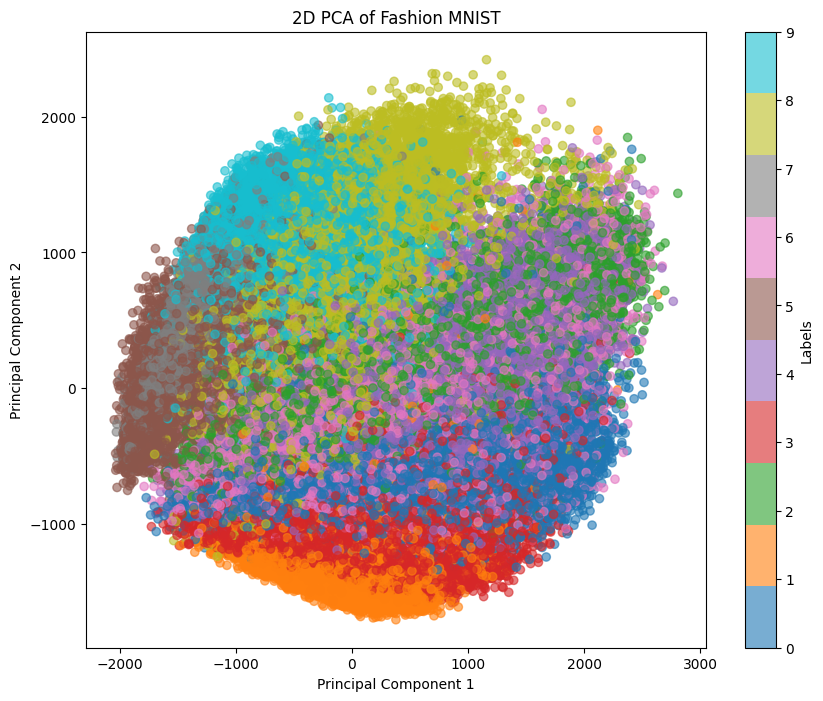

In [14]:

# # 데이터를 1차원으로 변환하여 PCA에 맞게 준비
# train_images = train_dataset.data.numpy().reshape(-1, 28*28)  # (N, 784)
# train_labels = train_dataset.targets.numpy()

# PCA 모델 생성 (2개의 주성분 유지)
pca = PCA(n_components=2)
train_images_pca = pca.fit_transform(train_images)

# 시각화
plt.figure(figsize=(10, 8))
scatter = plt.scatter(train_images_pca[:, 0], train_images_pca[:, 1], c=train_labels, cmap="tab10", alpha=0.6)
plt.colorbar(scatter, label='Labels')
plt.title("2D PCA of Fashion MNIST")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()



## T-SNE

### 앞서 pca를 통해 50차원으로 줄인 데이터를 t-sne를 통해 시각화 하세요.



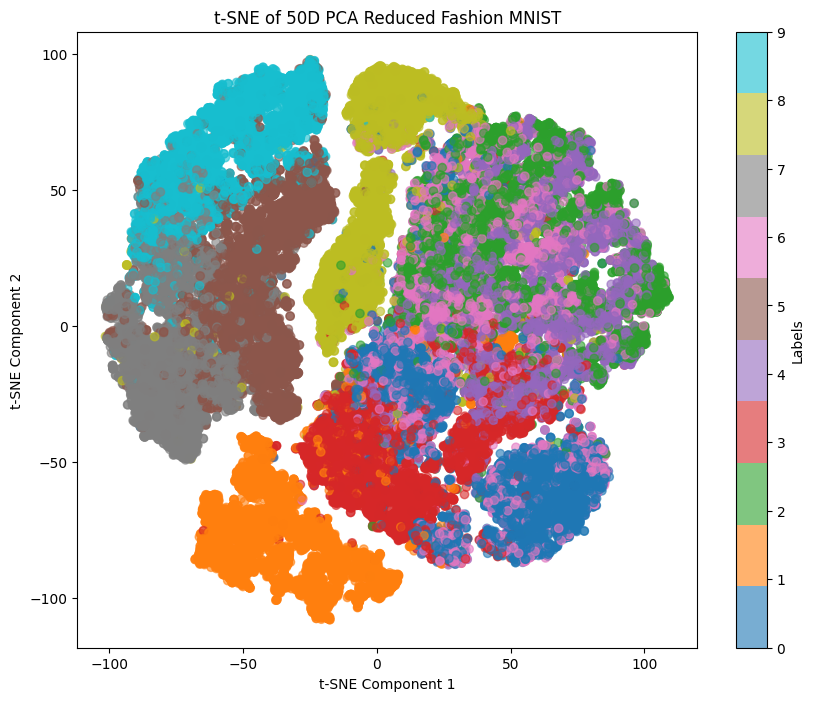

In [15]:
# PCA 모델 생성 (50개의 주성분 유지)
pca = PCA(n_components=50)
train_images_pca = pca.fit_transform(train_images)

# t-SNE 모델 생성 및 50차원 데이터를 2차원으로 축소
tsne = TSNE(n_components=2, random_state=42)
train_images_tsne = tsne.fit_transform(train_images_pca)  # PCA로 50차원으로 축소된 데이터를 t-SNE로 2차원으로 축소

# t-SNE 시각화
plt.figure(figsize=(10, 8))
scatter = plt.scatter(train_images_tsne[:, 0], train_images_tsne[:, 1], c=train_labels, cmap="tab10", alpha=0.6)
plt.colorbar(scatter, label='Labels')
plt.title("t-SNE of 50D PCA Reduced Fashion MNIST")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()


### 앞서 pca를 통해 30차원으로 줄인 데이터를 t-sne를 통해 시각화 하세요.


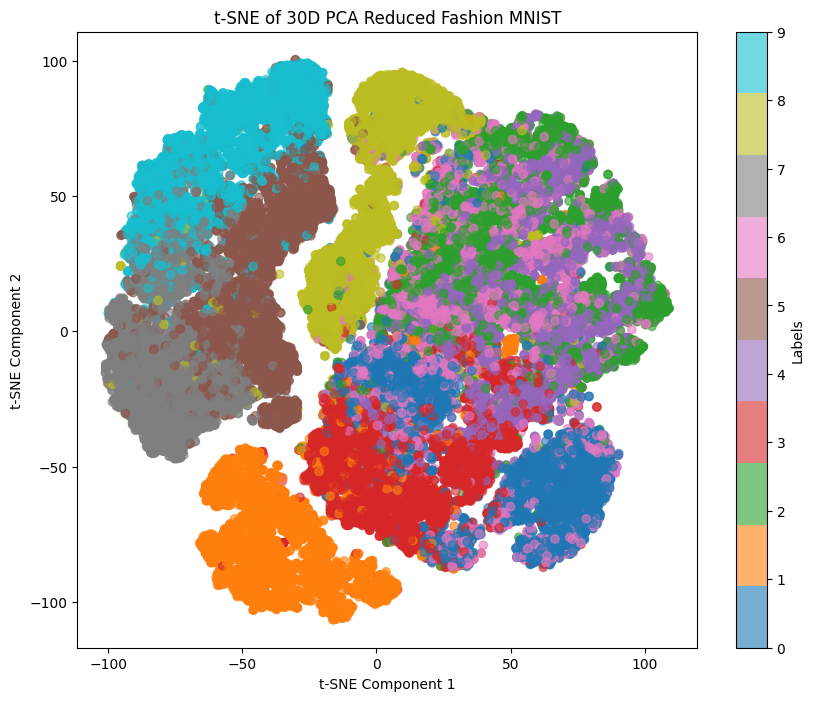

In [ ]:

# PCA 모델 생성 (30개의 주성분 유지)
pca_30 = PCA(n_components=30)
train_images_pca_30 = pca_30.fit_transform(train_images)

# t-SNE 모델 생성 및 30차원 데이터를 2차원으로 축소
tsne_30 = TSNE(n_components=2, random_state=42)
train_images_tsne_30 = tsne_30.fit_transform(train_images_pca_30)  # PCA로 30차원으로 축소된 데이터를 t-SNE로 2차원으로 축소

# t-SNE 시각화
plt.figure(figsize=(10, 8))
scatter = plt.scatter(train_images_tsne_30[:, 0], train_images_tsne_30[:, 1], c=train_labels, cmap="tab10", alpha=0.6)
plt.colorbar(scatter, label='Labels')
plt.title("t-SNE of 30D PCA Reduced Fashion MNIST")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()


## 군집화

### PCA를 통해 50차원으로 줄인 데이터를 DBSCAN을 이용하여 군집화 하시오.



In [ ]:
# 데이터 표준화
scaler = StandardScaler()
train_images_scaled = scaler.fit_transform(train_images)  # StandardScaler로 데이터 표준화

# PCA 모델 생성 (50개의 주성분 유지)
pca_50 = PCA(n_components=50)
train_images_pca_50 = pca_50.fit_transform(train_images_scaled)

# DBSCAN을 통한 군집화 수행
dbscan = DBSCAN(eps=3, min_samples=5)  # eps와 min_samples는 필요에 따라 조정 가능
dbscan_labels = dbscan.fit_predict(train_images_pca_50)

# DBSCAN 결과 출력
unique_labels = set(dbscan_labels)
num_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
print("Number of clusters (excluding noise):", num_clusters)
print("Cluster labels:", unique_labels)


Number of clusters (excluding noise): 90
Cluster labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, -1}


### k-means를 통해 50차원으로 줄인 데이터를 군집화 하시오.(군집의 개수는 10개로 하시오.)

In [ ]:
# K-means를 통한 군집화 수행 (군집 개수=10)
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans_labels = kmeans.fit_predict(train_images_pca_50)

# K-means 결과 출력
print("Cluster centers shape:", kmeans.cluster_centers_.shape)  # 각 군집의 중심 좌표
print("Cluster labels for each sample:", kmeans_labels[:20])  # 각 샘플의 군집 레이블 중 첫 20개 출력
print("Inertia (Sum of squared distances to nearest cluster center):", kmeans.inertia_)  # K-means의 관성 (inertia) 출력


Cluster centers shape: (10, 50)
Cluster labels for each sample: [3 8 1 1 0 2 7 2 1 1 8 5 7 7 7 3 4 8 2 1]
Inertia (Sum of squared distances to nearest cluster center): 16823605.054919463


### 엘보우 메소드를 이용하여 k-means에서 가장 적절한 군집의 개수를 구하시오.

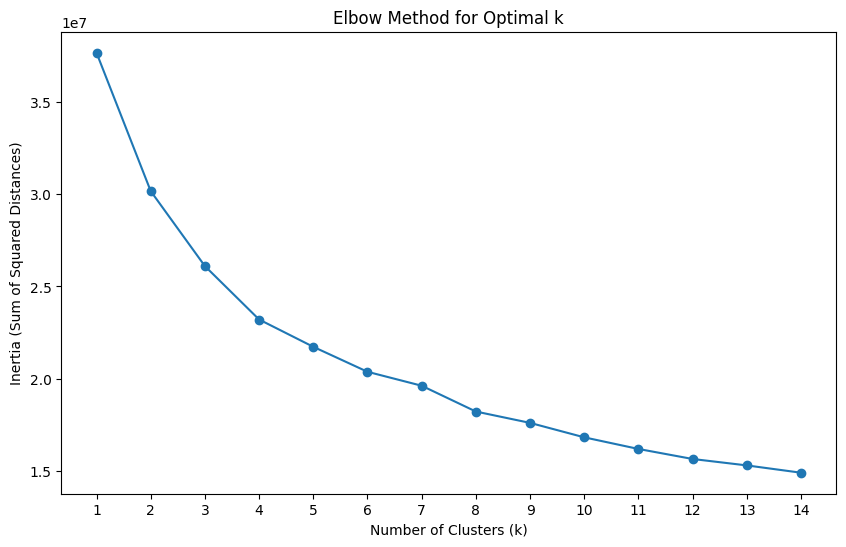

In [ ]:
# 엘보우 메소드를 위한 관성 값 계산
inertia_values = []
k_range = range(1, 15)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(train_images_pca_50)
    inertia_values.append(kmeans.inertia_)

# 엘보우 그래프 시각화
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia_values, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Sum of Squared Distances)")
plt.xticks(k_range)
plt.show()


### k-means 최적의 군집 개수로 다시 군집화 하여 시각화 하시오.

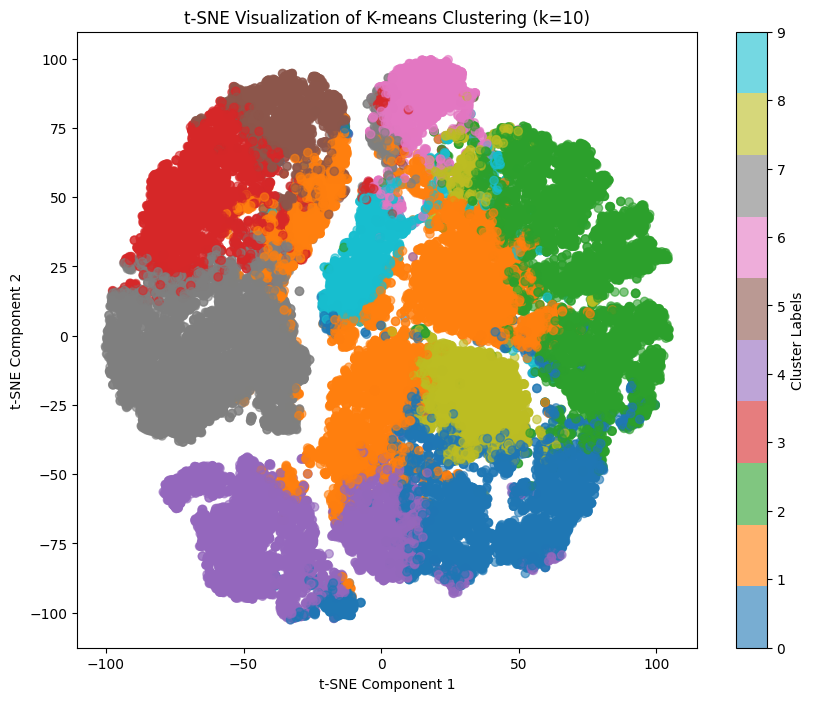

In [ ]:
optimal_k = 10  # 엘보우 메소드에서 얻은 최적 군집 개수, 필요 시 최적 값으로 수정

# K-means를 통한 군집화 수행 (최적 군집 개수로 설정)
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels_optimal = kmeans_optimal.fit_predict(train_images_pca_50)

# 2차원으로 시각화하기 위해 t-SNE로 차원 축소
tsne_optimal = TSNE(n_components=2, random_state=42)
train_images_tsne_optimal = tsne_optimal.fit_transform(train_images_pca_50)

# K-means 군집 결과 시각화
plt.figure(figsize=(10, 8))
scatter = plt.scatter(train_images_tsne_optimal[:, 0], train_images_tsne_optimal[:, 1], c=kmeans_labels_optimal, cmap="tab10", alpha=0.6)
plt.colorbar(scatter, label='Cluster Labels')
plt.title(f"t-SNE Visualization of K-means Clustering (k={optimal_k})")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()


### 다른 추가적인 군집화 기법을 2가지 이상 사용하여 pca 50 데이터를 시각화 하시오.

In [ ]:
# 1. 계층적 군집화 (Hierarchical Clustering) - Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=10)  # 군집 개수를 10개로 설정
agg_labels = agg_clustering.fit_predict(train_images_pca_50)

# 2. 밀도 기반 군집화 (Density-Based Clustering) - DBSCAN
dbscan_clustering = DBSCAN(eps=3, min_samples=5)  # 파라미터는 필요에 따라 조정 가능
dbscan_labels = dbscan_clustering.fit_predict(train_images_pca_50)

# 시각화를 위해 t-SNE로 차원 축소 (2D)
tsne_agg = TSNE(n_components=2, random_state=42)
train_images_tsne_agg = tsne_agg.fit_transform(train_images_pca_50)

# Agglomerative Clustering 시각화
plt.figure(figsize=(10, 8))
scatter = plt.scatter(train_images_tsne_agg[:, 0], train_images_tsne_agg[:, 1], c=agg_labels, cmap="tab10", alpha=0.6)
plt.colorbar(scatter, label='Agglomerative Cluster Labels')
plt.title("t-SNE Visualization of Agglomerative Clustering (k=10)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

# DBSCAN 시각화
plt.figure(figsize=(10, 8))
scatter = plt.scatter(train_images_tsne_agg[:, 0], train_images_tsne_agg[:, 1], c=dbscan_labels, cmap="tab10", alpha=0.6)
plt.colorbar(scatter, label='DBSCAN Cluster Labels')
plt.title("t-SNE Visualization of DBSCAN Clustering")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()


100%|██████████| 26.4M/26.4M [00:02<00:00, 12.3MB/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 209kB/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.88MB/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 3.20MB/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



## 군집화 결과 비교

### 앞선 모든 군집화 모델의 결과를 실루엣 점수(Silhouette score)를 이용하여 성능을 비교하시오.

In [ ]:
# 1. K-means 클러스터링 (k=10) 실루엣 점수 계산
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans_labels = kmeans.fit_predict(train_images_pca_50)
kmeans_silhouette = silhouette_score(train_images_pca_50, kmeans_labels)

# 2. Agglomerative Clustering (계층적 군집화, k=10) 실루엣 점수 계산
agg_clustering = AgglomerativeClustering(n_clusters=10)
agg_labels = agg_clustering.fit_predict(train_images_pca_50)
agg_silhouette = silhouette_score(train_images_pca_50, agg_labels)

# 3. DBSCAN 실루엣 점수 계산
dbscan = DBSCAN(eps=3, min_samples=5)
dbscan_labels = dbscan.fit_predict(train_images_pca_50)
# DBSCAN의 경우 일부 레이블이 -1일 수 있으므로 -1을 제외하고 실루엣 점수 계산
dbscan_silhouette = silhouette_score(train_images_pca_50, dbscan_labels, metric='euclidean') if len(set(dbscan_labels)) > 1 else None

# 결과 출력
print("Silhouette Score for K-means (k=10):", kmeans_silhouette)
print("Silhouette Score for Agglomerative Clustering (k=10):", agg_silhouette)
print("Silhouette Score for DBSCAN:", dbscan_silhouette)


### 실루엣 점수를 통해 군집화 모델의 성능에 대한 간단한 해석을 적으세요.

K-means (k=10): 실루엣 점수는 각 군집의 응집력과 분리도를 고려한 값으로, 1에 가까울수록 군집화가 잘된 것을 의미합니다.
Agglomerative Clustering (k=10): 계층적 군집화에서의 실루엣 점수를 통해 데이터의 군집이 얼마나 잘 형성되었는지 확인할 수 있습니다.
DBSCAN: 밀도 기반 군집화에서는 노이즈 포인트가 포함될 수 있어 일부 군집이 잘 구분되지 않을 경우 실루엣 점수가 낮아질 수 있습니다.
실루엣 점수 해석
실루엣 점수가 높을수록 군집 내 데이터는 밀집되어 있고, 군집 간의 데이터는 잘 분리되어 있음을 나타냅니다.
점수가 낮다면 군집 간의 경계가 모호하거나, 잘못된 군집 개수를 설정했을 가능성이 있습니다.
